# <mark>Attention!</mark>

This project was originally made in the Russian language. It takes quite a lot of effort to manually translate everything into English. So in order to understand what is going on here, **please download the .ipynb and use an automatic Google page translator in your Jupyter Notebook**. It does a pretty decent job!

P.S. `All further projects are made in English.`

# Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

# Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# Импортируем библиотеки и открываем датасеты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import plotly.express as px
import warnings
#import plotly.offline as pyo
import plotly.io as pio
import time


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

pio.renderers.default = "svg"
#pyo.init_notebook_mode()
%matplotlib inline
warnings.filterwarnings('ignore')

# Открываем файл с данными и изучаем его.

In [2]:
# file loading for Windows
try: 
    data = pd.read_csv('datasets/users_behavior.csv')
    
# file loading for Linux(?)    
except:
    data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


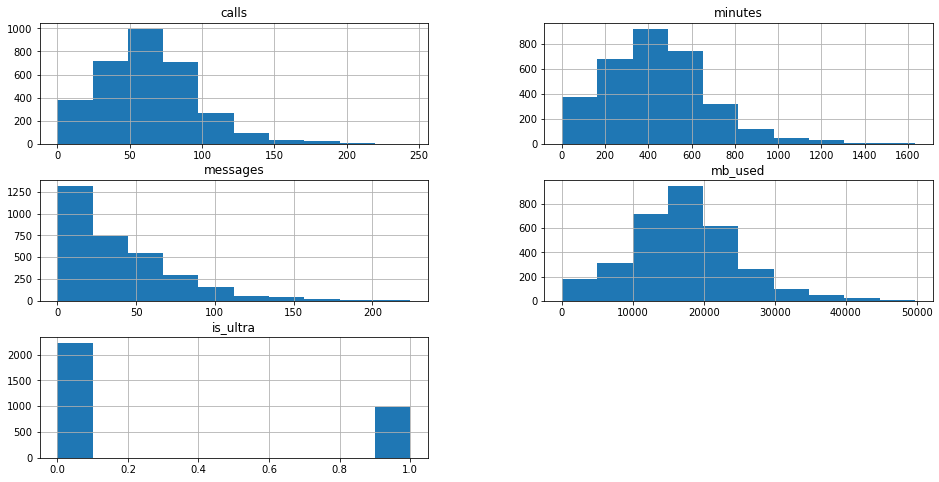

In [5]:
data.hist(figsize=(16, 8))
plt.show()

In [6]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


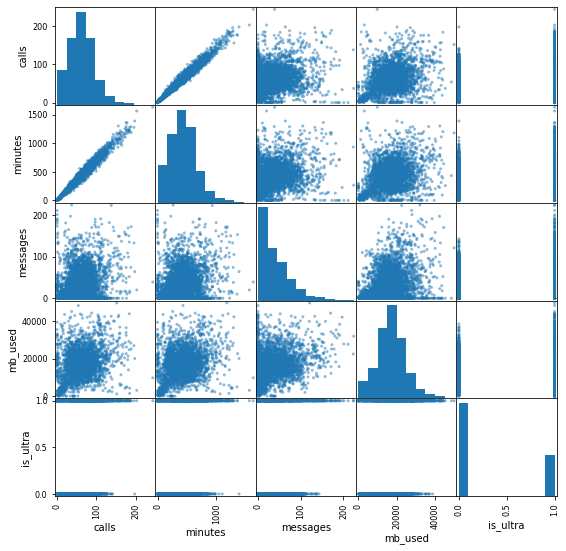

In [7]:
pd.plotting.scatter_matrix(data, figsize=(9, 9))
plt.show()

In [8]:
# удаляем колонку со звонками
data.drop(['calls'], axis=1, inplace=True)

**Промежуточный вывод:** данные в хорошем состоянии, нет пропусков. Можно было бы заменить некоторые типы данных, но так как файл маленький и особо толку от этого нету - делать мы это не будем. Так же была обнаружена мультиколинеарность звонков и использованных минут. Мультиколлинеарность может не так сильно влиять на точность модели, но мы можем потерять надежность при определении влияния отдельных независимых функций на зависимую функцию в вашей модели, и это может стать проблемой, когда мы хотим интерпретировать нашу модель. Учитывая, что в тарифы включены именно минуты, а не кол-во звонков, то колонку со звонками мы можем удалить.

# Разделим исходные данные на обучающую, валидационную и тестовую выборки

In [9]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

features_train, features_rem, target_train, target_rem = train_test_split(features, target, test_size=0.3, random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(features_rem, target_rem, test_size=0.5, random_state=42)

In [10]:
print(f'Общий размер выборки признаков:{features.shape}, целевой признак: {target.shape}')
print(f'Размер выборки признаков для обучения:{features_train.shape}, целевых признаков для обучения: {target_train.shape}')
print(f'Размер выборки признаков для валидации:{features_valid.shape}, целевых признаков для валидации: {target_valid.shape}')
print(f'Размер выборки признаков для тестов:{features_test.shape}, целевых признаков для валидации: {target_test.shape}')

Общий размер выборки признаков:(3214, 3), целевой признак: (3214,)
Размер выборки признаков для обучения:(2249, 3), целевых признаков для обучения: (2249,)
Размер выборки признаков для валидации:(482, 3), целевых признаков для валидации: (482,)
Размер выборки признаков для тестов:(483, 3), целевых признаков для валидации: (483,)


In [11]:
# проконтроллируем размер выборок
print(f'Размер обучающей выборки: {round(features_train.shape[0] / features.shape[0], 2)}')
print(f'Размер валидационной выборки: {round(features_valid.shape[0] / features.shape[0], 2)}')
print(f'Размер тестовой выборки: {round(features_test.shape[0] / features.shape[0], 2)}')

Размер обучающей выборки: 0.7
Размер валидационной выборки: 0.15
Размер тестовой выборки: 0.15


# Исследуем качество разных моделей, меняя гиперпараметры.
## Решающее дерево


Accuracy of the best model on validation features = 0.815
Accuracy of the best model on test features = 0.762
depth of the best model = 13


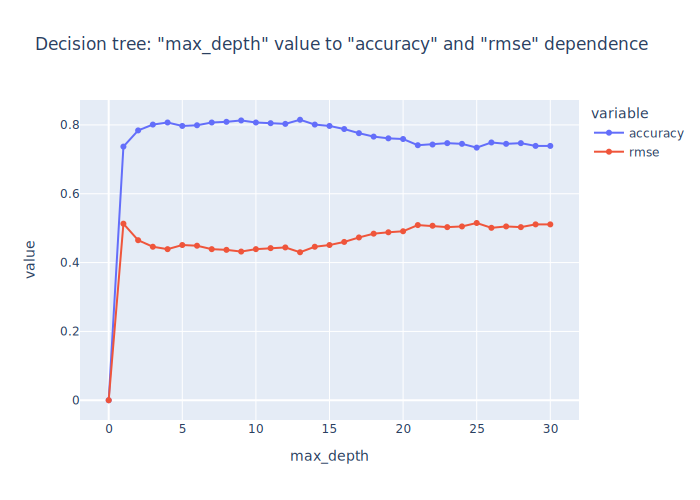

Execution time is: 5.8 seconds


In [12]:
# DecisionTreeClassifier
start = time.time()

best_model= None
accuracy = 0
best_depth = 0
best_result = 1000

# создаём датафрейм для результатов теста
result_df = pd.DataFrame({'max_depth': [0], 'accuracy': [0], 'rmse': [0]})
for depth in range(1, 31):
    # initialize and fit the model
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_train, target_train)

    # make predictions of the fitted model and make and an accuracy test
    predictions = model.predict(features_valid)
    accuracy_test = accuracy_score(predictions, target_valid)
    result = mean_squared_error(target_valid, predictions) ** 0.5
    
    # записываем результаты в таблицу
    result_df.loc[depth] = (depth, round(accuracy_test, 3), round(result, 3))
    
#    print(f'depth = {depth}')
#    print(f'accuracy_test = {round(accuracy_test, 3)}')
    if accuracy_test > accuracy:
        best_model = model
        best_depth = depth
#        print(f'accuracy old = {round(accuracy, 3)}')
        accuracy = accuracy_test
#        print(f'accuracy new = {round(accuracy, 3)}')
        

accuracy_test_valid = accuracy_score(best_model.predict(features_valid), target_valid)
accuracy_test_test = accuracy_score(best_model.predict(features_test), target_test)
print('')
print(f'Accuracy of the best model on validation features = {round(accuracy_test_valid, 3)}')
print(f'Accuracy of the best model on test features = {round(accuracy_test_test, 3)}')
print(f'depth of the best model = {best_depth}')
    
fig = px.line(result_df, x='max_depth', y=['accuracy', 'rmse'], markers=True,
              title='Decision tree: "max_depth" value to "accuracy" and "rmse" dependence')
fig.show()

end = time.time()
print(f'Execution time is: {round(end - start, 1)} seconds')

**Промежуточный вывод:** для решающего дерева, оптимальной будет **`depth` = 13**, далее пойдёт переобучение или излишняя глубина, которая почти не влияет на результат. Лучший результат **`accuracy`= 0.815** на валидационной выборке. На тестовой же выборке эта модель показывает результат **`accuracy`= 0.762**. Время исполнения теста = **0.4 секунды**

## Случайный лес


Accuracy of the best model on validation features = 0.817
Accuracy of the best model on test features = 0.781
n_estimators of the best model = 18


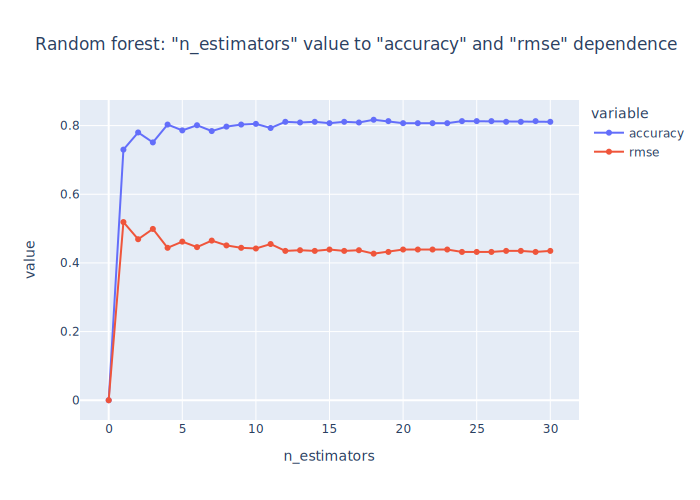

Execution time is: 2.7 seconds


In [13]:
# RandomForestClassifier
start = time.time()

best_model= None
accuracy = 0
best_n_estimators = 0
best_result = 1000

# создаём датафрейм для результатов теста
result_df = pd.DataFrame({'n_estimators': [0], 'accuracy': [0], 'rmse': [0]})
for est in range(1,31):
    # определяем модель с заданным количеством деревьев и обучаем её
    model = RandomForestClassifier(random_state=42, n_estimators=est)
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    accuracy_test = accuracy_score(predictions, target_valid)
    result = mean_squared_error(target_valid, predictions) ** 0.5
    # записываем результаты в таблицу
    result_df.loc[est] = (est, round(accuracy_test, 3), round(result, 3))
    
#    print(f'depth = {depth}')
#    print(f'accuracy_test = {round(accuracy_test, 3)}')
    if accuracy_test > accuracy:
        best_model = model
        best_n_estimators = est
#        print(f'accuracy old = {round(accuracy, 3)}')
        accuracy = accuracy_test
#        print(f'accuracy new = {round(accuracy, 3)}')

accuracy_test_valid = accuracy_score(best_model.predict(features_valid), target_valid)
accuracy_test_test = accuracy_score(best_model.predict(features_test), target_test)
print('')
print(f'Accuracy of the best model on validation features = {round(accuracy_test_valid, 3)}')
print(f'Accuracy of the best model on test features = {round(accuracy_test_test, 3)}')
print(f'n_estimators of the best model = {best_n_estimators}')

# рисуем график
fig = px.line(result_df, x='n_estimators', y=['accuracy', 'rmse'], markers=True,
              title='Random forest: "n_estimators" value to "accuracy" and "rmse" dependence')
fig.show()

end = time.time()
print(f'Execution time is: {round(end - start, 1)} seconds')

**Промежуточный вывод:** оптимальное значение **`n_estimators`= 18**. Лучший результат **`accuracy` = 0.817** на валидационной выборке. На тестовой выборке **`accuracy` = 0.781**. Время исполнения всего теста = **2.0 секунды** 

## Логистическая регрессия

In [14]:
#LogisticRegression
start = time.time()

model = LogisticRegression(random_state=42)
model.fit(features_train, target_train)

#result = mean_squared_error(target_valid, predictions) ** 0.5

predictions_valid = model.predict(features_valid)
predictions_test = model.predict(features_test)

accuracy_test_valid = accuracy_score(predictions_valid, target_valid)
accuracy_test_test = accuracy_score(predictions_test, target_test)

print(f"Accuracy on validation features = {round(accuracy_test_valid, 3)}")
print(f"Accuracy on test features = {round(accuracy_test_test, 3)}")

end = time.time()
print(f'Execution time is: {round(end - start, 1)} seconds')

Accuracy on validation features = 0.766
Accuracy on test features = 0.723
Execution time is: 0.1 seconds


**Промежуточный вывод:** Лучший результат **`accuracy` = 0.766** на валидационной и **`accuracy` = 0.723** тестовой выборках. Время исполнения теста = **0.0 секунд**. Модель нам не подходит.

## Дерево решений в регрессии

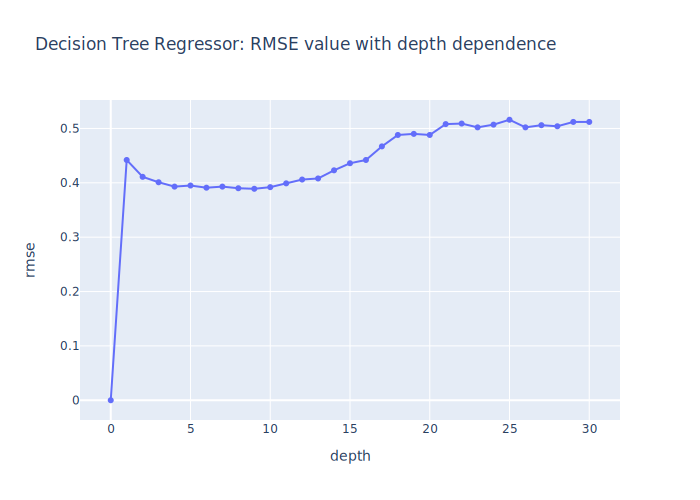

RMSE наилучшей модели на валидационной выборке: 0.389 Глубина дерева: 9
Accuracy на валидационной выборке ~ 0.762

RMSE наилучшей модели на тестовой выборке: 0.413
Accuracy на тестовой выборке ~ 0.809
Execution time is: 0.7 seconds


In [15]:
# DecisionTreeRegressor
start = time.time()

# создаём датафрейм для результатов теста
result_df = pd.DataFrame({'depth': [0], 'rmse': [0]})

best_model= None
best_result = 1000
best_depth = 0
accuracy = 0

for depth in range(1, 31):
    model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions) ** 0.5
    #print("RMSE модели на валидационной выборке:", round(result, 3), "Глубина дерева:", depth)
    result_df.loc[depth] = (depth, round(result, 3))
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
        accuracy = accuracy_test

predictions = best_model.predict(features_test)        
best_result_test = mean_squared_error(target_test, predictions) ** 0.5
        
# рисуем график
fig = px.line(result_df, x='depth', y='rmse', markers=True,
              title='Decision Tree Regressor: RMSE value with depth dependence')
fig.show()

end = time.time()
print("RMSE наилучшей модели на валидационной выборке:", round(best_result, 3), "Глубина дерева:", best_depth)
print(f"Accuracy на валидационной выборке ~ {round(best_result * 1.96, 3)}")
print('')
print("RMSE наилучшей модели на тестовой выборке:", round(best_result_test, 3))
print(f"Accuracy на тестовой выборке ~ {round(best_result_test * 1.96, 3)}")
print(f'Execution time is: {round(end - start, 1)} seconds')

**According to NDEP (National Digital Elevation Guidelines) and FEMA guidelines, a measure of accuracy can be computed: Accuracy = 1.96 * RMSE.**


**Промежуточный вывод:** Используя эту информацию, на валидационной выборке **`accuracy` ~ 0.762**, а на тестовой выборке **`accuracy` ~ 0.809**. Время теста составляет 0.4 секунды.

## Случайный лес в регрессии

In [16]:
# RandomForestRegressor
start = time.time()

# создаём датафрейм для результатов теста
result_df = pd.DataFrame({'depth': [0], 'rmse': [0]})

best_model= None
best_result = 1000
best_depth = 0
best_est = 0

for est in range(1, 31):
    for depth in range(1, 11):
        model = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators = est)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = mean_squared_error(target_valid, predictions) ** 0.5
        #print("RMSE модели на валидационной выборке:", round(result, 3), "Глубина дерева:", depth)
        result_df.loc[depth] = (depth, round(result, 3))
        if result < best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est
        
# рисуем график
# fig = px.line(result_df, x='depth', y='rmse', markers=True,
#               title='Random Forest Regressor: RMSE value with depth dependence')
# fig.show()

predictions = best_model.predict(features_test)        
best_result_test = mean_squared_error(target_test, predictions) ** 0.5

end = time.time()
print("RMSE наилучшей модели на валидационной выборке:", round(best_result, 3), ". Количество деревьев:",
      best_est, "Максимальная глубина:", depth)
print(f"Accuracy на валидационной выборке ~ {round(best_result * 1.96, 3)}")
print('')
print("RMSE наилучшей модели на тестовой выборке:", round(best_result_test, 3))
print(f"Accuracy на тестовой выборке ~ {round(best_result_test * 1.96, 3)}")
print(f'Execution time is: {round(end - start, 1)} seconds')

RMSE наилучшей модели на валидационной выборке: 0.369 . Количество деревьев: 28 Максимальная глубина: 10
Accuracy на валидационной выборке ~ 0.723

RMSE наилучшей модели на тестовой выборке: 0.397
Accuracy на тестовой выборке ~ 0.778
Execution time is: 18.1 seconds


**Промежуточный вывод:** Используя эту информацию, на валидационной выборке **`accuracy` ~ 0.723**, а на тестовой выборке **`accuracy` ~ 0.778**. Не прошли барьер требуемой точности в задании. К тому же время исполнения огромное, по сравнению с другими моделями. Учитывая такую разницу в точности, эту модель использовать не будем.

# Проверим модели на вменяемость.

In [17]:
# импортируем фиктивный классификатор
from sklearn.dummy import DummyClassifier

start = time.time()

dummy_model = DummyClassifier()
dummy_model.fit(features_train, target_train)

predictions_valid = dummy_model.predict(features_valid)
predictions_test = dummy_model.predict(features_test)

accuracy_test_valid = accuracy_score(predictions_valid, target_valid)
accuracy_test_test = accuracy_score(predictions_test, target_test)

print(f"Accuracy on validation features = {round(accuracy_test_valid, 3)}")
print(f"Accuracy on test features = {round(accuracy_test_test, 3)}")

end = time.time()
print(f'Execution time is: {round(end - start, 1)} seconds')

Accuracy on validation features = 0.707
Accuracy on test features = 0.66
Execution time is: 0.0 seconds


**Промежуточный вывод:** как видим, использование DummyClassifier, который делает прогнозы, которые игнорируют входные функции приводит к значению **`accuracy` = не выше 0.6** в обоих случаях, которое не дотягивает до установленного в задании уровня 0.75 довольно значительно.

# Вывод:

В данном задании мы разбили базу данных на обучающую и валидационную выборки. Целевым показателем служило наличие или отсутствие тарифа `Ультра`. Было обнаружено, что колонка `звонки` и `минуты` мультиколинеарна, потому звонки пришлось удалить. Мы обучили модели, которые будут предсказывать, является ли пользователь владельцем данного тарифа или нет.

**Случайный лес** и **Дерево решений в регрессии** показали наилучшие результаты по сравнению с остальными моделями машинного обучения. Часть моделей не преодолели коэффициента 0.75 точности в поставленной в задаче.  В то же время, модель Dummy Classifier, которая делает прогнозы, игнорируя входные функции показала результат `accuracy` < 0.6, что почти является худшим из результатов.